In [1]:
#plotting and data analysis for global cold wakes
#from netCDF4 import Dataset  # http://code.google.com/p/netcdf4-python/
import os
import time
import datetime as dt
import xarray as xr
from datetime import datetime
import pandas
import matplotlib.pyplot as plt
import numpy as np
import math
####################you will need to change some paths here!#####################
#list of input directories
dir_storm_info='f:/data/tc_wakes/database/info/'
dir_out='f:/data/tc_wakes/database/sst/'
dir_flux = 'F:/data/model_data/oaflux/data_v3/daily/turbulence/'
dir_cmc = 'F:/data/sst/cmc/CMC0.2deg/v2/'
dir_ccmp='F:/data/sat_data/ccmp/v02.0/Y'
##where to get the data through opendap, use these directories instead
#dir_cmc = 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/CMC/CMC0.1deg/v3/'
#dir_flux = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/WHOI_OAFlux/version3/daily/lh_oaflux/'
#the latest ccmp is from www.remss.com but they do not have an opendap server so you can use this instead:
#dir_ccmp='https://podaac-opendap.jpl.nasa.gov/opendap/allData/ccmp/L3.0/flk/'

#################################################################################
import geopy.distance
from math import sin, pi
from scipy import interpolate

#functions for running storm data
import sys
#sys.path.append('C:/Users/gentemann/Google Drive/d_drive/python/storm_heat_content/subroutines/')
#from storm_masking_routines import interpolate_storm_path
#from storm_masking_routines import get_dist_grid
#from storm_masking_routines import closest_dist
#from storm_masking_routines import calculate_storm_mask



In [ ]:

#plot output data and mask

import os
dir_out_figures = 'F:/data/tc_wakes/database/figs/check_storm_dist/'
iyr_storm,inum_storm = 2003,27
for inum_storm in range(1,58): #100):
    filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_interpolated_track.nc'
    exists = os.path.isfile(filename)
    if not exists:
        continue
    print(filename)
    ds_storm=xr.open_dataset(filename)
    ds_storm = ds_storm.sel(j2=0)
    ds_storm.close()
#    ds_storm['lon'] = (ds_storm.lon + 180) % 360 - 180
    filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_combined_data.nc'
    ds_all = xr.open_dataset(filename)
    ds_all.close()
    #ds_all = ds_all.sortby('lon')
    print(ds_all.lon[0].values,ds_all.lon[-1].values)
    if abs(ds_all.lon[-1]-ds_all.lon[0])>180:
        ds_all.coords['lon'] = np.mod(ds_all['lon'], 360)
        #ds_all = ds_all.sortby(ds_all.lon)
        ds_storm['lon'] = np.mod(ds_storm['lon'], 360)
        #ds_storm = ds_storm.sortby(ds_storm.lon)
    plt.figure(figsize=(15,3.5))
    plt.subplot(131)
    ds_all.side_of_storm.plot()
    plt.plot(ds_storm.lon,ds_storm.lat,'w')
    plt.plot(ds_storm.lon[0],ds_storm.lat[0],'w*')
    plt.subplot(132)
    ds_all.dist_from_storm_km.plot(vmin=0,vmax=3000)
    plt.plot(ds_storm.lon,ds_storm.lat,'w')
    max_lat = ds_storm.lat.max()
    if max_lat<0:
        cond = ((ds_all.dist_from_storm_km<100) & (ds_all.side_of_storm<=0)) |  ((ds_all.dist_from_storm_km<800) & (ds_all.side_of_storm>0))
    else:
        cond = ((ds_all.dist_from_storm_km<800) & (ds_all.side_of_storm<0)) |  ((ds_all.dist_from_storm_km<100) & (ds_all.side_of_storm>=0))
    subset = ds_all.where(cond)
    plt.subplot(133)
    subset.dist_from_storm_km.plot(vmin=0,vmax=3000)
    plt.plot(ds_storm.lon,ds_storm.lat,'w')
    filename = dir_out_figures + str(iyr_storm) + str(inum_storm).zfill(3) + '_interpolated_track.png'
    plt.savefig(filename,dpi=100,bbox_inches='tight')
    plt.close()

In [2]:
map_lats=np.arange(-90,90,.25)
map_lats[0,0]

IndexError: too many indices for array

In [3]:

# coding: utf-8

# In[1]:

#trying to rewrite so faster using numpy historgram
#plotting and data analysis for global cold wakes
#from netCDF4 import Dataset  # http://code.google.com/p/netcdf4-python/
import os
import time
import datetime as dt
import xarray as xr
from datetime import datetime
import pandas
import matplotlib.pyplot as plt
import numpy as np
import math
import geopy.distance
from math import sin, pi
from scipy import interpolate
from scipy import stats

#functions for running storm data
import sys

####################you will need to change some paths here!#####################
#list of input directories
dir_storm_info='f:/data/tc_wakes/database/info/'
dir_out='f:/data/tc_wakes/database/sst/'
#################################################################################

#start to look at data and make some pdfs

date_1858 = dt.datetime(1858,11,17,0,0,0) # start date is 11/17/1958

map_lats=np.arange(-90,90,.25)
map_lons=np.arange(-180,180,.25)
imap_lats = map_lats.size
imap_lons = map_lons.size
  
for iyr_storm in range(2002,2017):
    #init arrays
    init_data=0
    map_sum,map_cnt,map_max = np.zeros([imap_lats,imap_lons]),np.zeros([imap_lats,imap_lons]),np.zeros([imap_lats,imap_lons])
    for inum_storm in range(0,100): #(0,100): #100):
        filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_interpolated_track.nc'
        exists = os.path.isfile(filename)
        if not exists:
            continue
        print(filename)
        ds_storm_info=xr.open_dataset(filename)
        ds_storm_info = ds_storm_info.sel(j2=0)
        ds_storm_info.close()
        filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_combined_data.nc'
        ds_all = xr.open_dataset(filename)
        ds_all['spd']=np.sqrt(ds_all.uwnd**2+ds_all.vwnd**2)
        ds_all.close()
        if abs(ds_all.lon[-1]-ds_all.lon[0])>180:
            ds_all.coords['lon'] = np.mod(ds_all['lon'], 360)
            ds_storm_info['lon'] = np.mod(ds_storm_info['lon'], 360)
        max_lat = ds_storm_info.lat.max()
        #remove all data outsice 100km/800km or cold wake >0 or <-10
        if max_lat<0:
            cond = ((((ds_all.dist_from_storm_km<100) & (ds_all.side_of_storm<=0)) | 
            ((ds_all.dist_from_storm_km<800) & (ds_all.side_of_storm>0))) 
            & (ds_all.coldwake_max<=-.1) & (ds_all.coldwake_max>=-10))
        else:
            cond = ((((ds_all.dist_from_storm_km<800) & (ds_all.side_of_storm<0)) | 
            ((ds_all.dist_from_storm_km<100) & (ds_all.side_of_storm>=0))) 
            & (ds_all.coldwake_max<=-.1) & (ds_all.coldwake_max>=-10))
        subset = ds_all.where(cond)

        #create coldwake anomaly with nan for all values before wmo storm time
        subset['sst_anomaly']=subset.analysed_sst-subset.sst_prestorm
    #    for i in range(0,xdim):
    #        for j in range (0,ydim):
    #            if np.isnan(subset.closest_storm_index[j,i]):
    #                continue
    #            iend = subset.closest_storm_index[j,i].data.astype(int)
    #            subset.sst_anomaly[:iend,j,i]=np.nan

        #create array with day.frac since closest storm passage
        tdif_dy = (subset.time-subset.closest_storm_time_np64)/np.timedelta64(1, 'D')
    #    tdif_dy = tdif_dy.where(tdif_dy>=0,np.nan)
        subset['tdif_dy']=tdif_dy

        xdim,ydim,tdim = ds_all.lon.shape[0],ds_all.lat.shape[0],ds_all.time.shape[0]

        pdim=xdim*ydim
        pdim3=tdim*xdim*ydim
        print(xdim*ydim)
#        data = subset.coldwake_max
#        cbin1 = np.arange(-10, 0, 0.1)  #cold wake bins
#        bins=cbin1
#        hist1,mids = np.histogram(data,bins)[0],0.5*(bins[1:]+bins[:-1])
#        sum1 = np.cumsum(mids*hist1) 

        cbin1 = np.arange(-10, 0, 0.1)  #cold wake bins
        bins=cbin1
        x= np.reshape(subset.coldwake_max.data,(pdim))
        v = np.reshape(subset.coldwake_max.data,(pdim))
        hist1,mids1=stats.binned_statistic(x,v,'count', bins)[0],0.5*(bins[1:]+bins[:-1])
        sum1=stats.binned_statistic(x,v, 'sum', bins)[0]

        cbin2 = np.arange(0,8)  #day to max, plot histogram of when cold wake max happens
        bins=cbin2
        x= np.reshape(subset.coldwake_hrtomaxcold.data/24,(pdim))
        v = np.reshape(subset.coldwake_max.data,(pdim))
        hist2,mids2=stats.binned_statistic(x,v,'count', bins)[0],0.5*(bins[1:]+bins[:-1])
        sum2=stats.binned_statistic(x,v, 'sum', bins)[0]

        cbin3 = np.arange(0,50)  #dy to recovery
        bins=cbin3
        x= np.reshape(subset.coldwake_dytorecovery.data,(pdim))
        v = np.reshape(subset.coldwake_max.data,(pdim))
        hist3,mids3=stats.binned_statistic(x,v,'count', bins)[0],0.5*(bins[1:]+bins[:-1])
        sum3=stats.binned_statistic(x,v, 'sum', bins)[0]

        cbin4 = np.arange(0,600,3)  #max cold wake as function of MLD at start of storm
        bins=cbin4
        x= np.reshape(subset.dbss_obml[0,:,:].data,(pdim))
        v = np.reshape(subset.coldwake_max.data,(pdim))
        hist4,mids4=stats.binned_statistic(x,v,'count', bins)[0],0.5*(bins[1:]+bins[:-1])
        sum4=stats.binned_statistic(x,v, 'sum', bins)[0]

        cbin5 = np.arange(0,200)  #max cold wake as function of wmo max storm wind speed
        bins=cbin5
        x= np.reshape(subset.wmo_storm_wind.data,(pdim))
        v = np.reshape(subset.coldwake_max.data,(pdim))
        hist5,mids5=stats.binned_statistic(x,v,'count', bins)[0],0.5*(bins[1:]+bins[:-1])
        sum5=stats.binned_statistic(x,v, 'sum', bins)[0]

        cbin6 = np.arange(0,400,2)  #max cold wake as function of wmo max storm translation speed
        bins=cbin6
        x= np.reshape(subset.wmo_storm_speed.data,(pdim))
        v = np.reshape(subset.coldwake_max.data,(pdim))
        hist6,mids6=stats.binned_statistic(x,v,'count', bins)[0],0.5*(bins[1:]+bins[:-1])
        sum6=stats.binned_statistic(x,v, 'sum', bins)[0]

        cbin7 = np.arange(-10,50,1)  #cold wake recovery as function of time
        bins = cbin7
        x= np.reshape(subset.tdif_dy.data,(pdim3))
        v = np.reshape(subset.sst_anomaly.data,(pdim3))
        hist7,mids7=stats.binned_statistic(x,v,'count', bins)[0],0.5*(bins[1:]+bins[:-1])
        sum7=stats.binned_statistic(x,v, 'sum', bins)[0]

        x1= np.reshape(subset.wmo_storm_speed.data,(pdim))
        x3= np.reshape(subset.wmo_storm_wind.data,(pdim))
        b1= cbin6 #np.arange(0,200,1)
        b3= cbin5 #np.arange(0,200,1)
        dbins=np.vstack((b1,b3)).T
        v = np.reshape(subset.coldwake_max.data,(pdim))
        hist8=stats.binned_statistic_2d(x1,x3,v,'count', bins=dbins.T)[0]
        sum8=stats.binned_statistic_2d(x1,x3,v, 'sum', bins=dbins.T)[0]

        x1= np.reshape(subset.wmo_storm_speed.data,(pdim))
        x2= np.reshape(subset.dbss_obml[0,:,:].data,(pdim))
        x3= np.reshape(subset.wmo_storm_wind.data,(pdim))
        x=np.vstack((x1,x2,x3))
        b1= cbin6 #np.arange(0,200,1)
        b2= cbin4 #np.arange(0,600,3)
        b3= cbin5 #np.arange(0,200,1)
        dbins=np.vstack((b1,b2,b3)).T
        v = np.reshape(subset.coldwake_max.data,(pdim))
        hist9=stats.binned_statistic_dd(x.T,v,'count', bins=dbins.T)[0]
        sum9=stats.binned_statistic_dd(x.T,v, 'sum', bins=dbins.T)[0]    

        if init_data == 0:
            sv_sum1,sv_cnt1,sv_bin1 = sum1,hist1,cbin1
            sv_sum2,sv_cnt2,sv_bin2 = sum2,hist2,cbin2
            sv_sum3,sv_cnt3,sv_bin3 = sum3,hist3,cbin3
            sv_sum4,sv_cnt4,sv_bin4 = sum4,hist4,cbin4
            sv_sum5,sv_cnt5,sv_bin5 = sum5,hist5,cbin5
            sv_sum6,sv_cnt6,sv_bin6 = sum6,hist6,cbin6
            sv_sum7,sv_cnt7,sv_bin7 = sum7,hist7,cbin7
            sv_sum8,sv_cnt8 = sum8,hist8
            sv_sum9,sv_cnt9 = sum9,hist9
            init_data=1
        else:
            sv_sum1+= sum1
            sv_cnt1+= hist1
            sv_sum2+= sum2
            sv_cnt2+= hist2
            sv_sum3+= sum3
            sv_cnt3+= hist3
            sv_sum4+= sum4
            sv_cnt4+= hist4
            sv_sum5+= sum5
            sv_cnt5+= hist5      
            sv_sum6+= sum6
            sv_cnt6+= hist6           
            sv_sum7+= sum7
            sv_cnt7+= hist7           
            sv_sum8+= sum8
            sv_cnt8+= hist8           
            sv_sum9+= sum9
            sv_cnt9+= hist9           

        #put on global map
        tem = subset.coldwake_max.interp(lat=map_lats,lon=map_lons)
        tem=tem.fillna(0)
        temc=(tem/tem).fillna(0)
        map_sum+=tem
        map_cnt+=temc
        map_max=np.where(tem.data < map_max, tem,map_max)  #where tem<max put tem value in otherwise leave max

    m1=xr.DataArray(map_sum, coords={'lat': map_lats, 'lon':map_lons}, dims=('lat', 'lon'))        
    m2=xr.DataArray(map_cnt, coords={'lat': map_lats, 'lon':map_lons}, dims=('lat', 'lon'))        
    m3=xr.DataArray(map_max, coords={'lat': map_lats, 'lon':map_lons}, dims=('lat', 'lon'))        
    ds=xr.Dataset(data_vars={'sum1': (('coldw'),sv_sum1),
                             'cnt1': (('coldw'),sv_cnt1),
                             'sum2': (('dymax'),sv_sum2),
                             'cnt2': (('dymax'),sv_cnt2),
                             'sum3': (('dyrec'),sv_sum3),
                             'cnt3': (('dyrec'),sv_cnt3),
                             'sum4': (('mld'),sv_sum4),
                             'cnt4': (('mld'),sv_cnt4),
                             'sum5': (('wnd'),sv_sum5),
                             'cnt5': (('wnd'),sv_cnt5),
                             'sum6': (('tspd'),sv_sum6),
                             'cnt6': (('tspd'),sv_cnt6),
                             'sum7': (('dtime'),sv_sum7),
                             'cnt7': (('dtime'),sv_cnt7),
                             'sum8': (('tspd','wnd'),sv_sum8),
                             'cnt8': (('tspd','wnd'),sv_cnt8),
                             'sum9': (('tspd','mld','wnd'),sv_sum9),
                             'cnt9': (('tspd','mld','wnd'),sv_cnt9),
                                 'map_sum': (('lat','lon'),m1),
                                'map_cnt': (('lat','lon'),m2),
                                'map_max': (('lat','lon'),m3)
                               },
                                 coords={'coldw':cbin1[0:-1],
                                         'dymax':cbin2[0:-1],
                                         'dyrec':cbin3[0:-1],
                                         'mld':cbin4[0:-1],
                                         'wnd':cbin5[0:-1],
                                         'tspd':cbin6[0:-1],
                                         'dtime':cbin7[0:-1],
                                         'lat':map_lats,'lon':map_lons})

    filename='f:/data/tc_wakes/database/results/hist_sum_'+str(iyr_storm)+'.nc'
    ds.to_netcdf(filename)


f:/data/tc_wakes/database/sst/2002/001_interpolated_track.nc
27405


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/002_interpolated_track.nc
21016


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/005_interpolated_track.nc
43032


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/007_interpolated_track.nc
9483


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/009_interpolated_track.nc
39644


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/010_interpolated_track.nc
19932


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/011_interpolated_track.nc
21710


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/012_interpolated_track.nc
10881


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/013_interpolated_track.nc
25792


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/014_interpolated_track.nc
18330


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/015_interpolated_track.nc
23790


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/017_interpolated_track.nc
36815


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/018_interpolated_track.nc
29896


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/019_interpolated_track.nc
17822


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/020_interpolated_track.nc
24336


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/021_interpolated_track.nc
17898


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/022_interpolated_track.nc
13464


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/023_interpolated_track.nc
8730


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/025_interpolated_track.nc
54000


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/027_interpolated_track.nc
15042


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/028_interpolated_track.nc
25418


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/030_interpolated_track.nc
44022


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/031_interpolated_track.nc
27811


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/033_interpolated_track.nc
72336


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/034_interpolated_track.nc
14883


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/035_interpolated_track.nc
19380


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/036_interpolated_track.nc
55377


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/037_interpolated_track.nc
32025


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/039_interpolated_track.nc
20049


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/040_interpolated_track.nc
23843


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/041_interpolated_track.nc
34362


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/042_interpolated_track.nc
12519


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/043_interpolated_track.nc
11232


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/046_interpolated_track.nc
62248


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/047_interpolated_track.nc
13356


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/048_interpolated_track.nc
20298


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/049_interpolated_track.nc
66933


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/050_interpolated_track.nc
54707


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/051_interpolated_track.nc
61640


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/052_interpolated_track.nc
18104


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/053_interpolated_track.nc
34304


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/054_interpolated_track.nc
23460


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/055_interpolated_track.nc
20708


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/056_interpolated_track.nc
9790


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/058_interpolated_track.nc
9810


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/060_interpolated_track.nc
10948


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/061_interpolated_track.nc
39376


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/063_interpolated_track.nc
40800


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/064_interpolated_track.nc
14637


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/066_interpolated_track.nc
51156


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/067_interpolated_track.nc
11433


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/068_interpolated_track.nc
25254


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/069_interpolated_track.nc
49504


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/070_interpolated_track.nc
37742


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/072_interpolated_track.nc
47174


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/075_interpolated_track.nc
13795


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/077_interpolated_track.nc
41728


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/081_interpolated_track.nc
37149


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/082_interpolated_track.nc
11200


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/083_interpolated_track.nc
33123


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2002/084_interpolated_track.nc
10904


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/002_interpolated_track.nc
23283


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/003_interpolated_track.nc
42570


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/004_interpolated_track.nc
39203


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/005_interpolated_track.nc
22932


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/006_interpolated_track.nc
22630


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/008_interpolated_track.nc
20224


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/009_interpolated_track.nc
20468


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/010_interpolated_track.nc
18542


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/011_interpolated_track.nc
54120


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/012_interpolated_track.nc
15618


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/013_interpolated_track.nc
36764


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/015_interpolated_track.nc
22692


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/016_interpolated_track.nc
15207


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/017_interpolated_track.nc
17985


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/018_interpolated_track.nc
24990


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/019_interpolated_track.nc
18415


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/021_interpolated_track.nc
13056


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/022_interpolated_track.nc
20496


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/023_interpolated_track.nc
44960


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/024_interpolated_track.nc
29106


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/025_interpolated_track.nc
13000


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/026_interpolated_track.nc
45582


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/027_interpolated_track.nc
16875


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/028_interpolated_track.nc
44544


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/031_interpolated_track.nc
28728


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/032_interpolated_track.nc
23989


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/033_interpolated_track.nc
16048


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/034_interpolated_track.nc
37050


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/035_interpolated_track.nc
24139


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/036_interpolated_track.nc
53502


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/037_interpolated_track.nc
46200


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/038_interpolated_track.nc
12971


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/040_interpolated_track.nc
50668


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/042_interpolated_track.nc
8188


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/044_interpolated_track.nc
19328


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/046_interpolated_track.nc
47520


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/047_interpolated_track.nc
18408


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/048_interpolated_track.nc
40920


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/049_interpolated_track.nc
25461


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/050_interpolated_track.nc
20864


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/051_interpolated_track.nc
22752


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/055_interpolated_track.nc
44469


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/057_interpolated_track.nc
15372


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/059_interpolated_track.nc
15770


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/060_interpolated_track.nc
41464


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/064_interpolated_track.nc
11024


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/065_interpolated_track.nc
27720


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/066_interpolated_track.nc
61046


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/067_interpolated_track.nc
20865


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/070_interpolated_track.nc
45978


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/071_interpolated_track.nc
12420


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/072_interpolated_track.nc
13260


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/073_interpolated_track.nc
60604


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/075_interpolated_track.nc
13520


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/076_interpolated_track.nc
60844


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/077_interpolated_track.nc
16240


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/078_interpolated_track.nc
54102


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/079_interpolated_track.nc
14940


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/080_interpolated_track.nc
80370


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/081_interpolated_track.nc
12566


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/082_interpolated_track.nc
12535


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/083_interpolated_track.nc
12296


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/086_interpolated_track.nc
35088


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/087_interpolated_track.nc
30972


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/088_interpolated_track.nc
32850


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/089_interpolated_track.nc
14523


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/091_interpolated_track.nc
19278


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/092_interpolated_track.nc
10416


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/093_interpolated_track.nc
24888


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/094_interpolated_track.nc
45582


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/095_interpolated_track.nc
30264


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2003/097_interpolated_track.nc
15576


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/001_interpolated_track.nc
8827


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/002_interpolated_track.nc
22560


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/003_interpolated_track.nc
37555


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/004_interpolated_track.nc
11872


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/005_interpolated_track.nc
12600


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/006_interpolated_track.nc
22440


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/007_interpolated_track.nc
32942


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/008_interpolated_track.nc
23430


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/009_interpolated_track.nc
31234


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/011_interpolated_track.nc
17820


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/012_interpolated_track.nc
43200


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/013_interpolated_track.nc
12987


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/014_interpolated_track.nc
12638


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/015_interpolated_track.nc
29145


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/016_interpolated_track.nc
21252


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/017_interpolated_track.nc
22816


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/018_interpolated_track.nc
17516


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/019_interpolated_track.nc
17869


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/021_interpolated_track.nc
58236


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/022_interpolated_track.nc
10528


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/023_interpolated_track.nc
18864


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/024_interpolated_track.nc
40874


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/025_interpolated_track.nc
15048


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/026_interpolated_track.nc
8836


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/028_interpolated_track.nc
69122


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/029_interpolated_track.nc
23919


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/030_interpolated_track.nc
7380


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/031_interpolated_track.nc
11448


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/032_interpolated_track.nc
71466


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/033_interpolated_track.nc
36417


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/034_interpolated_track.nc
51624


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/037_interpolated_track.nc
16224


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/038_interpolated_track.nc
22360


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/039_interpolated_track.nc
17052


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/040_interpolated_track.nc
28640


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/041_interpolated_track.nc
21276


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/043_interpolated_track.nc
39783


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/044_interpolated_track.nc
21098


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/045_interpolated_track.nc
26578


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/046_interpolated_track.nc
41952


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/047_interpolated_track.nc
24888


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/048_interpolated_track.nc
25862


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/049_interpolated_track.nc
34825


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/051_interpolated_track.nc
30798


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/052_interpolated_track.nc
54175


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/053_interpolated_track.nc
60775


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/054_interpolated_track.nc
30602


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/055_interpolated_track.nc
16900


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/058_interpolated_track.nc
63000


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/059_interpolated_track.nc
71346


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/060_interpolated_track.nc
27120


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/062_interpolated_track.nc
45966


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/063_interpolated_track.nc
25276


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/064_interpolated_track.nc
68706


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/065_interpolated_track.nc
22792


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/066_interpolated_track.nc
18800


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/068_interpolated_track.nc
24800


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/069_interpolated_track.nc
29492


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/071_interpolated_track.nc
30096


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/072_interpolated_track.nc
98307


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/073_interpolated_track.nc
36284


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/074_interpolated_track.nc
31106


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/075_interpolated_track.nc
9720


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/076_interpolated_track.nc
27176


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/081_interpolated_track.nc
69160


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/084_interpolated_track.nc
41832


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/087_interpolated_track.nc
23870


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/089_interpolated_track.nc
13608


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/091_interpolated_track.nc
33522


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/092_interpolated_track.nc
36315


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2004/093_interpolated_track.nc
27885


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/002_interpolated_track.nc
25038


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/003_interpolated_track.nc
24576


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/004_interpolated_track.nc
31730


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/005_interpolated_track.nc
12696


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/006_interpolated_track.nc
16626


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/007_interpolated_track.nc
25272


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/009_interpolated_track.nc
6888


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/010_interpolated_track.nc
15795


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/011_interpolated_track.nc
25585


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/012_interpolated_track.nc
32038


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/014_interpolated_track.nc
21009


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/015_interpolated_track.nc
17346


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/016_interpolated_track.nc
26271


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/017_interpolated_track.nc
55692


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/018_interpolated_track.nc
9312


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/019_interpolated_track.nc
7744


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/020_interpolated_track.nc
53680


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/021_interpolated_track.nc
17125


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/022_interpolated_track.nc
37604


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/023_interpolated_track.nc
21717


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/024_interpolated_track.nc
16320


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/025_interpolated_track.nc
16303


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/026_interpolated_track.nc
25620


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/027_interpolated_track.nc
37828


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/028_interpolated_track.nc
30912


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/029_interpolated_track.nc
40136


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/031_interpolated_track.nc
36252


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/034_interpolated_track.nc
29032


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/035_interpolated_track.nc
23302


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/038_interpolated_track.nc
20406


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/042_interpolated_track.nc
38592


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/043_interpolated_track.nc
41710


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/044_interpolated_track.nc
43018


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/045_interpolated_track.nc
28560


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/047_interpolated_track.nc
19470


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/048_interpolated_track.nc
61997


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/049_interpolated_track.nc
34510


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/053_interpolated_track.nc
32390


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/055_interpolated_track.nc
33785


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/056_interpolated_track.nc
45627


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/057_interpolated_track.nc
21280


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/058_interpolated_track.nc
19089


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/060_interpolated_track.nc
14454


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/061_interpolated_track.nc
32680


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/062_interpolated_track.nc
30132


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/063_interpolated_track.nc
27560


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/065_interpolated_track.nc
20424


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/066_interpolated_track.nc
28800


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/067_interpolated_track.nc
16102


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/068_interpolated_track.nc
20358


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/069_interpolated_track.nc
53724


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/070_interpolated_track.nc
79254


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/071_interpolated_track.nc
33174


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/072_interpolated_track.nc
106596


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/073_interpolated_track.nc
37200


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/074_interpolated_track.nc
30240


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/078_interpolated_track.nc
24525


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/079_interpolated_track.nc
12420


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/081_interpolated_track.nc
17433


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/082_interpolated_track.nc
15707


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/083_interpolated_track.nc
26928


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/084_interpolated_track.nc
19947


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/085_interpolated_track.nc
41067


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/086_interpolated_track.nc
14190


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/087_interpolated_track.nc
21492


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/088_interpolated_track.nc
13108


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/093_interpolated_track.nc
19430


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/095_interpolated_track.nc
16125


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/096_interpolated_track.nc
13572


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/097_interpolated_track.nc
43780


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2005/099_interpolated_track.nc
9400


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/001_interpolated_track.nc
22800


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/002_interpolated_track.nc
16899


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/003_interpolated_track.nc
22650


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/006_interpolated_track.nc
14445


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/007_interpolated_track.nc
29440


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/008_interpolated_track.nc
24448


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/009_interpolated_track.nc
17280


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/010_interpolated_track.nc
10260


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/012_interpolated_track.nc
21659


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/014_interpolated_track.nc
34762


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/015_interpolated_track.nc
18094


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/016_interpolated_track.nc
33048


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/017_interpolated_track.nc
14883


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/018_interpolated_track.nc
16714


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/019_interpolated_track.nc
10170


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/021_interpolated_track.nc
19436


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/022_interpolated_track.nc
12744


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/023_interpolated_track.nc
28836


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/026_interpolated_track.nc
95532


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/027_interpolated_track.nc
17666


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/028_interpolated_track.nc
35358


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/029_interpolated_track.nc
11264


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/030_interpolated_track.nc
28906


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/031_interpolated_track.nc
27468


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/032_interpolated_track.nc
22200


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/033_interpolated_track.nc
31610


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/034_interpolated_track.nc
26520


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/037_interpolated_track.nc
26364


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/038_interpolated_track.nc
20984


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/040_interpolated_track.nc
16745


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/041_interpolated_track.nc
18900


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/042_interpolated_track.nc
9632


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/043_interpolated_track.nc
35520


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/044_interpolated_track.nc
27027


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/045_interpolated_track.nc
14260


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/047_interpolated_track.nc
20500


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/049_interpolated_track.nc
94482


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/050_interpolated_track.nc
24200


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/052_interpolated_track.nc
21120


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/053_interpolated_track.nc
30618


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/054_interpolated_track.nc
33970


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/055_interpolated_track.nc
22785


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/056_interpolated_track.nc
12648


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/057_interpolated_track.nc
14784


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/058_interpolated_track.nc
72588


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/060_interpolated_track.nc
29784


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/061_interpolated_track.nc
64241


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/062_interpolated_track.nc
71446


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/064_interpolated_track.nc
20398


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/065_interpolated_track.nc
9810


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/066_interpolated_track.nc
45738


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/067_interpolated_track.nc
7224


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/068_interpolated_track.nc
6888


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/070_interpolated_track.nc
17557


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/072_interpolated_track.nc
23142


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/073_interpolated_track.nc
19608


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/075_interpolated_track.nc
11648


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/076_interpolated_track.nc
36360


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/077_interpolated_track.nc
13524


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/078_interpolated_track.nc
13761


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/079_interpolated_track.nc
12402


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/080_interpolated_track.nc
21600


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/083_interpolated_track.nc
16368


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/086_interpolated_track.nc
9400


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/087_interpolated_track.nc
26664


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/088_interpolated_track.nc
20532


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2006/089_interpolated_track.nc
23956


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/001_interpolated_track.nc
10388


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/002_interpolated_track.nc
12648


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/003_interpolated_track.nc
16272


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/004_interpolated_track.nc
29640


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/005_interpolated_track.nc
13685


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/007_interpolated_track.nc
57918


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/008_interpolated_track.nc
25550


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/009_interpolated_track.nc
35953


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/010_interpolated_track.nc
10807


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/011_interpolated_track.nc
16680


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/012_interpolated_track.nc
33552


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/013_interpolated_track.nc
34760


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/014_interpolated_track.nc
23973


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/015_interpolated_track.nc
21016


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/016_interpolated_track.nc
15120


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/017_interpolated_track.nc
25272


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/018_interpolated_track.nc
11115


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/020_interpolated_track.nc
29040


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/021_interpolated_track.nc
28054


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/022_interpolated_track.nc
21783


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/024_interpolated_track.nc
13176


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/026_interpolated_track.nc
51798


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/027_interpolated_track.nc
14151


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/028_interpolated_track.nc
13468


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/030_interpolated_track.nc
14396


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/031_interpolated_track.nc
30492


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/035_interpolated_track.nc
72960


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/037_interpolated_track.nc
29795


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/039_interpolated_track.nc
19456


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/040_interpolated_track.nc
31504


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/041_interpolated_track.nc
64236


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/043_interpolated_track.nc
32936


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/045_interpolated_track.nc
22000


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/046_interpolated_track.nc
26069


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/047_interpolated_track.nc
41400


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/048_interpolated_track.nc
15996


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/049_interpolated_track.nc
28798


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/050_interpolated_track.nc
20440


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/052_interpolated_track.nc
24045


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/053_interpolated_track.nc
29944


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/055_interpolated_track.nc
21353


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/056_interpolated_track.nc
16016


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/058_interpolated_track.nc
21252


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/059_interpolated_track.nc
12753


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/060_interpolated_track.nc
8448


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/066_interpolated_track.nc
23302


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/067_interpolated_track.nc
12753


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/068_interpolated_track.nc
16815


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/069_interpolated_track.nc
60450


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/070_interpolated_track.nc
10608


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/071_interpolated_track.nc
35512


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/072_interpolated_track.nc
15820


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/073_interpolated_track.nc
29673


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/074_interpolated_track.nc
16740


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/075_interpolated_track.nc
37835


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/076_interpolated_track.nc
53268


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/078_interpolated_track.nc
20202


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/080_interpolated_track.nc
12696


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/081_interpolated_track.nc
14746


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/082_interpolated_track.nc
19154


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2007/083_interpolated_track.nc
20832


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/002_interpolated_track.nc
20008


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/003_interpolated_track.nc
8099


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/004_interpolated_track.nc
23718


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/005_interpolated_track.nc
13440


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/006_interpolated_track.nc
21080


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/007_interpolated_track.nc
15730


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/008_interpolated_track.nc
15972


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/009_interpolated_track.nc
12314


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/010_interpolated_track.nc
11058


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/012_interpolated_track.nc
23450


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/013_interpolated_track.nc
19668


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/014_interpolated_track.nc
29029


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/015_interpolated_track.nc
35739


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/016_interpolated_track.nc
36686


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/017_interpolated_track.nc
29450


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/018_interpolated_track.nc
13888


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/019_interpolated_track.nc
19557


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/020_interpolated_track.nc
27676


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/021_interpolated_track.nc
20829


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/022_interpolated_track.nc
21726


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/023_interpolated_track.nc
16166


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/024_interpolated_track.nc
21024


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/027_interpolated_track.nc
13104


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/028_interpolated_track.nc
31324


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/029_interpolated_track.nc
61662


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/031_interpolated_track.nc
44032


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/036_interpolated_track.nc
25102


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/037_interpolated_track.nc
20000


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/038_interpolated_track.nc
12408


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/040_interpolated_track.nc
64172


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/042_interpolated_track.nc
35476


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/043_interpolated_track.nc
30956


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/044_interpolated_track.nc
28428


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/046_interpolated_track.nc
24393


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/047_interpolated_track.nc
23422


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/048_interpolated_track.nc
19966


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/049_interpolated_track.nc
13500


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/051_interpolated_track.nc
21924


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/052_interpolated_track.nc
25016


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/055_interpolated_track.nc
44800


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/056_interpolated_track.nc
16686


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/057_interpolated_track.nc
20240


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/058_interpolated_track.nc
26690


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/060_interpolated_track.nc
37788


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/061_interpolated_track.nc
36477


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/062_interpolated_track.nc
62600


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/063_interpolated_track.nc
21218


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/065_interpolated_track.nc
12880


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/066_interpolated_track.nc
43725


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/068_interpolated_track.nc
26912


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/069_interpolated_track.nc
24480


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/070_interpolated_track.nc
21996


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/071_interpolated_track.nc
27864


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/072_interpolated_track.nc
24992


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/074_interpolated_track.nc
19836


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/075_interpolated_track.nc
19182


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/077_interpolated_track.nc
15194


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/079_interpolated_track.nc
32922


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/086_interpolated_track.nc
17582


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/087_interpolated_track.nc
16074


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/088_interpolated_track.nc
10368


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2008/093_interpolated_track.nc
17640


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/001_interpolated_track.nc
21146


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/002_interpolated_track.nc
11557


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/003_interpolated_track.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


19188
f:/data/tc_wakes/database/sst/2009/004_interpolated_track.nc
19040


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/005_interpolated_track.nc
25974


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/006_interpolated_track.nc
29722


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/008_interpolated_track.nc
25420


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/009_interpolated_track.nc
24402


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/011_interpolated_track.nc
13952


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/013_interpolated_track.nc
26676


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/014_interpolated_track.nc
23647


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/016_interpolated_track.nc
27599


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/017_interpolated_track.nc
17780


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/018_interpolated_track.nc
14859


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/020_interpolated_track.nc
27495


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/023_interpolated_track.nc
12760


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/025_interpolated_track.nc
25413


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/026_interpolated_track.nc
12036


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/027_interpolated_track.nc
9975


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/028_interpolated_track.nc
67230


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/029_interpolated_track.nc
21744


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/030_interpolated_track.nc
10004


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/032_interpolated_track.nc
76930


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/038_interpolated_track.nc
17324


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/040_interpolated_track.nc
15036


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/041_interpolated_track.nc
26550


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/045_interpolated_track.nc
14280


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/046_interpolated_track.nc
25560


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/047_interpolated_track.nc
19328


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/048_interpolated_track.nc
21462


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/049_interpolated_track.nc
40922


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/050_interpolated_track.nc
16005


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/052_interpolated_track.nc
48024


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/053_interpolated_track.nc
16646


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/054_interpolated_track.nc
75088


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/055_interpolated_track.nc
44176


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/057_interpolated_track.nc
24252


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/060_interpolated_track.nc
23856


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/061_interpolated_track.nc
16704


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/062_interpolated_track.nc
20002


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/065_interpolated_track.nc
14840


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/066_interpolated_track.nc
64960


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/068_interpolated_track.nc
36557


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/071_interpolated_track.nc
26522


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/072_interpolated_track.nc
17010


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/073_interpolated_track.nc
15386


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/074_interpolated_track.nc
14964


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/076_interpolated_track.nc
30654


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/078_interpolated_track.nc
30414


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/079_interpolated_track.nc
61446


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/080_interpolated_track.nc
17680


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/081_interpolated_track.nc
40275


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/083_interpolated_track.nc
74184


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/084_interpolated_track.nc
18189


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/085_interpolated_track.nc
19642


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/086_interpolated_track.nc
25774


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/087_interpolated_track.nc
17490


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/089_interpolated_track.nc
19448


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2009/090_interpolated_track.nc
9212


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/001_interpolated_track.nc
21930


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/002_interpolated_track.nc
14415


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/003_interpolated_track.nc
28755


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/004_interpolated_track.nc
22620


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/005_interpolated_track.nc
25560


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/007_interpolated_track.nc
32110


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/008_interpolated_track.nc
10324


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/010_interpolated_track.nc
18762


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/012_interpolated_track.nc
64214


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/015_interpolated_track.nc
26040


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/016_interpolated_track.nc
16605


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/017_interpolated_track.nc
13208


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/018_interpolated_track.nc
14278


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/019_interpolated_track.nc
19519


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/020_interpolated_track.nc
84051


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/021_interpolated_track.nc
14896


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/023_interpolated_track.nc
15836


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/024_interpolated_track.nc
10509


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/025_interpolated_track.nc
10028


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/026_interpolated_track.nc
15029


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/027_interpolated_track.nc
8448


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/028_interpolated_track.nc
11872


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/029_interpolated_track.nc
15860


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/031_interpolated_track.nc
16632


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/032_interpolated_track.nc
15159


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/034_interpolated_track.nc
19602


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/035_interpolated_track.nc
15260


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/036_interpolated_track.nc
18080


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/038_interpolated_track.nc
20520


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/040_interpolated_track.nc
16936


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/042_interpolated_track.nc
28086


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/043_interpolated_track.nc
14229


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/044_interpolated_track.nc
32148


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/045_interpolated_track.nc
12208


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/048_interpolated_track.nc
65148


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/049_interpolated_track.nc
17113


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/050_interpolated_track.nc
76659


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/051_interpolated_track.nc
12543


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/052_interpolated_track.nc
67200


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/054_interpolated_track.nc
28960


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/055_interpolated_track.nc
27216


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/056_interpolated_track.nc
22422


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/058_interpolated_track.nc
17340


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/059_interpolated_track.nc
31930


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/060_interpolated_track.nc
65527


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/061_interpolated_track.nc
34608


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/062_interpolated_track.nc
15444


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/063_interpolated_track.nc
14664


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/064_interpolated_track.nc
51051


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/065_interpolated_track.nc
13720


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/069_interpolated_track.nc
48970


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/071_interpolated_track.nc
12528


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/072_interpolated_track.nc
24072


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/074_interpolated_track.nc
30960


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/075_interpolated_track.nc
9408


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/076_interpolated_track.nc
12610


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/077_interpolated_track.nc
36252


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2010/079_interpolated_track.nc
14688


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/001_interpolated_track.nc
12769


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/002_interpolated_track.nc
17097


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/005_interpolated_track.nc
21200


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/006_interpolated_track.nc
9546


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/007_interpolated_track.nc
10416


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/008_interpolated_track.nc
32279


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/009_interpolated_track.nc
55282


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/010_interpolated_track.nc
24883


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/011_interpolated_track.nc
14385


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/012_interpolated_track.nc
26070


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/015_interpolated_track.nc
24327


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/016_interpolated_track.nc
30528


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/017_interpolated_track.nc
21307


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/018_interpolated_track.nc
41418


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/019_interpolated_track.nc
13054


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/020_interpolated_track.nc
31408


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/021_interpolated_track.nc
39900


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/022_interpolated_track.nc
16472


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/023_interpolated_track.nc
8280


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/024_interpolated_track.nc
15370


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/025_interpolated_track.nc
68493


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/026_interpolated_track.nc
64715


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/027_interpolated_track.nc
16170


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/030_interpolated_track.nc
23241


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/031_interpolated_track.nc
11224


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/033_interpolated_track.nc
23862


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/035_interpolated_track.nc
16995


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/036_interpolated_track.nc
44304


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/038_interpolated_track.nc
22401


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/039_interpolated_track.nc
26352


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/042_interpolated_track.nc
19688


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/043_interpolated_track.nc
48060


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/045_interpolated_track.nc
30720


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/046_interpolated_track.nc
21021


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/047_interpolated_track.nc
26200


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/050_interpolated_track.nc
18522


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/051_interpolated_track.nc
20055


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/053_interpolated_track.nc
16254


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/054_interpolated_track.nc
35728


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/055_interpolated_track.nc
23432


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/058_interpolated_track.nc
101160


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/061_interpolated_track.nc
30134


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/062_interpolated_track.nc
12540


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/063_interpolated_track.nc
15912


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/064_interpolated_track.nc
47286


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/065_interpolated_track.nc
8549


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/066_interpolated_track.nc
57408


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/067_interpolated_track.nc
35700


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/068_interpolated_track.nc
48995


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/069_interpolated_track.nc
24442


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/071_interpolated_track.nc
50038


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/072_interpolated_track.nc
24592


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/074_interpolated_track.nc
18720


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/075_interpolated_track.nc
15429


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/076_interpolated_track.nc
13986


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/077_interpolated_track.nc
10791


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/078_interpolated_track.nc
19096


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/080_interpolated_track.nc
12180


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/081_interpolated_track.nc
10656


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/082_interpolated_track.nc
11016


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/083_interpolated_track.nc
21560


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/084_interpolated_track.nc
20370


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/085_interpolated_track.nc
17408


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/086_interpolated_track.nc
20286


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2011/087_interpolated_track.nc
11616


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/001_interpolated_track.nc
20304


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/002_interpolated_track.nc
13770


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/003_interpolated_track.nc
15000


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/004_interpolated_track.nc
24820


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/005_interpolated_track.nc
10584


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/006_interpolated_track.nc
11970


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/007_interpolated_track.nc
17557


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/008_interpolated_track.nc
28424


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/009_interpolated_track.nc
24311


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/010_interpolated_track.nc
17284


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/011_interpolated_track.nc
32256


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/013_interpolated_track.nc
28380


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/014_interpolated_track.nc
31293


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/015_interpolated_track.nc
26350


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/016_interpolated_track.nc
27888


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/017_interpolated_track.nc
14364


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/018_interpolated_track.nc
10829


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/019_interpolated_track.nc
31515


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/020_interpolated_track.nc
12120


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/021_interpolated_track.nc
13872


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/022_interpolated_track.nc
37286


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/023_interpolated_track.nc
14994


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/024_interpolated_track.nc
23718


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/025_interpolated_track.nc
65636


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/026_interpolated_track.nc
12126


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/027_interpolated_track.nc
36852


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/030_interpolated_track.nc
29088


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/032_interpolated_track.nc
22860


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/033_interpolated_track.nc
27072


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/034_interpolated_track.nc
31304


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/035_interpolated_track.nc
23166


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/036_interpolated_track.nc
24734


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/037_interpolated_track.nc
20001


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/038_interpolated_track.nc
23244


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/039_interpolated_track.nc
28217


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/040_interpolated_track.nc
30738


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/041_interpolated_track.nc
22374


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/042_interpolated_track.nc
21000


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/043_interpolated_track.nc
33319


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/044_interpolated_track.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


16820
f:/data/tc_wakes/database/sst/2012/045_interpolated_track.nc
35872


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/046_interpolated_track.nc
21507


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/047_interpolated_track.nc
13144


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/048_interpolated_track.nc
30680


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/049_interpolated_track.nc
23714


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/050_interpolated_track.nc
72275


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/051_interpolated_track.nc
48198


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/053_interpolated_track.nc
27686


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/054_interpolated_track.nc
55250


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/055_interpolated_track.nc
30560


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/056_interpolated_track.nc
19716


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/057_interpolated_track.nc
16263


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/058_interpolated_track.nc
25833


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/059_interpolated_track.nc
32592


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/060_interpolated_track.nc
17856


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/061_interpolated_track.nc
13552


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/062_interpolated_track.nc
68781


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/063_interpolated_track.nc
13794


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/064_interpolated_track.nc
37050


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/066_interpolated_track.nc
13563


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/067_interpolated_track.nc
47925


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/069_interpolated_track.nc
63732


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/073_interpolated_track.nc
77311


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/074_interpolated_track.nc
23490


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/076_interpolated_track.nc
27354


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/077_interpolated_track.nc
23716


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/078_interpolated_track.nc
21625


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/080_interpolated_track.nc
11832


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/081_interpolated_track.nc
9592


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/083_interpolated_track.nc
33948


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2012/085_interpolated_track.nc
17860


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/001_interpolated_track.nc
25058


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/002_interpolated_track.nc
12480


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/003_interpolated_track.nc
26535


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/004_interpolated_track.nc
27968


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/005_interpolated_track.nc
35372


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/007_interpolated_track.nc
16950


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/008_interpolated_track.nc
21715


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/009_interpolated_track.nc
24436


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/010_interpolated_track.nc
13968


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/011_interpolated_track.nc
20276


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/012_interpolated_track.nc
50440


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/013_interpolated_track.nc
10290


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/014_interpolated_track.nc
28855


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/016_interpolated_track.nc
16263


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/017_interpolated_track.nc
21960


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/018_interpolated_track.nc
15698


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/019_interpolated_track.nc
14652


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/020_interpolated_track.nc
19110


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/021_interpolated_track.nc
15120


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/022_interpolated_track.nc
29143


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/023_interpolated_track.nc
17220


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/025_interpolated_track.nc
11817


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/026_interpolated_track.nc
17920


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/031_interpolated_track.nc
21646


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/032_interpolated_track.nc
63288


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/033_interpolated_track.nc
15552


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/035_interpolated_track.nc
27625


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/036_interpolated_track.nc
24640


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/037_interpolated_track.nc
13431


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/038_interpolated_track.nc
17766


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/039_interpolated_track.nc
28067


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/042_interpolated_track.nc
52470


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/043_interpolated_track.nc
25410


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/044_interpolated_track.nc
17980


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/045_interpolated_track.nc
19400


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/047_interpolated_track.nc
25500


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/049_interpolated_track.nc
24890


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/050_interpolated_track.nc
37290


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/051_interpolated_track.nc
26076


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/052_interpolated_track.nc
36481


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/053_interpolated_track.nc
16748


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/054_interpolated_track.nc
18924


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/055_interpolated_track.nc
15142


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/057_interpolated_track.nc
16740


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/060_interpolated_track.nc
11856


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/061_interpolated_track.nc
9632


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/062_interpolated_track.nc
16965


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/063_interpolated_track.nc
16268


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/066_interpolated_track.nc
30080


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/067_interpolated_track.nc
10890


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/068_interpolated_track.nc
54635


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/069_interpolated_track.nc
12840


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/070_interpolated_track.nc
19712


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/071_interpolated_track.nc
51948


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/072_interpolated_track.nc
13912


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/073_interpolated_track.nc
24568


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/074_interpolated_track.nc
21756


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/076_interpolated_track.nc
30251


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/078_interpolated_track.nc
13440


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/079_interpolated_track.nc
16900


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/080_interpolated_track.nc
17640


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/081_interpolated_track.nc
62952


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/083_interpolated_track.nc
12840


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/084_interpolated_track.nc
29097


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/085_interpolated_track.nc
47952


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/086_interpolated_track.nc
16688


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/087_interpolated_track.nc
12928


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/088_interpolated_track.nc
23217


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/089_interpolated_track.nc
10032


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/091_interpolated_track.nc
41307


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/094_interpolated_track.nc
34650


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/095_interpolated_track.nc
9048


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/096_interpolated_track.nc
15730


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2013/098_interpolated_track.nc
10918


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/001_interpolated_track.nc
18576


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/002_interpolated_track.nc
18762


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/003_interpolated_track.nc
16240


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/004_interpolated_track.nc
29370


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/005_interpolated_track.nc
16280


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/006_interpolated_track.nc
26733


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/008_interpolated_track.nc
22050


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/009_interpolated_track.nc
25702


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/010_interpolated_track.nc
8178


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/011_interpolated_track.nc
14640


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/014_interpolated_track.nc
17415


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/016_interpolated_track.nc
14430


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/017_interpolated_track.nc
16640


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/018_interpolated_track.nc
26847


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/019_interpolated_track.nc
21809


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/020_interpolated_track.nc
24966


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/021_interpolated_track.nc
26576


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/022_interpolated_track.nc
49062


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/023_interpolated_track.nc
24311


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/024_interpolated_track.nc
20532


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/025_interpolated_track.nc
32469


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/026_interpolated_track.nc
31320


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/028_interpolated_track.nc
14552


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/029_interpolated_track.nc
15876


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/030_interpolated_track.nc
37914


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/031_interpolated_track.nc
14948


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/033_interpolated_track.nc
13216


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/034_interpolated_track.nc
13300


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/036_interpolated_track.nc
11025


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/038_interpolated_track.nc
10600


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/039_interpolated_track.nc
16498


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/042_interpolated_track.nc
59428


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/043_interpolated_track.nc
21484


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/044_interpolated_track.nc
38191


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/046_interpolated_track.nc
45936


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/048_interpolated_track.nc
39620


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/049_interpolated_track.nc
14544


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/050_interpolated_track.nc
31044


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/053_interpolated_track.nc
75200


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/054_interpolated_track.nc
21648


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/055_interpolated_track.nc
38701


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/056_interpolated_track.nc
17864


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/057_interpolated_track.nc
73476


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/058_interpolated_track.nc
31978


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/059_interpolated_track.nc
50505


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/061_interpolated_track.nc
19344


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/062_interpolated_track.nc
27720


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/063_interpolated_track.nc
38465


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/064_interpolated_track.nc
84240


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/066_interpolated_track.nc
16384


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/067_interpolated_track.nc
39606


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/068_interpolated_track.nc
15120


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/069_interpolated_track.nc
20100


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/070_interpolated_track.nc
25134


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/071_interpolated_track.nc
35150


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/072_interpolated_track.nc
21824


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/073_interpolated_track.nc
28080


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/074_interpolated_track.nc
16100


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/075_interpolated_track.nc
36808


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/076_interpolated_track.nc
53244


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/077_interpolated_track.nc
20100


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/078_interpolated_track.nc
73014


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/079_interpolated_track.nc
18626


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/081_interpolated_track.nc
50676


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/082_interpolated_track.nc
53130


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/084_interpolated_track.nc
13132


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/085_interpolated_track.nc
10848


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/086_interpolated_track.nc
16384


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/087_interpolated_track.nc
36828


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2014/090_interpolated_track.nc
33375


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/001_interpolated_track.nc
17898


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/002_interpolated_track.nc
24600


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/003_interpolated_track.nc
28208


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/004_interpolated_track.nc
30056


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/005_interpolated_track.nc
18630


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/006_interpolated_track.nc
35322


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/008_interpolated_track.nc
20020


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/009_interpolated_track.nc
24339


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/010_interpolated_track.nc
19781


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/011_interpolated_track.nc
17064


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/012_interpolated_track.nc
12495


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/013_interpolated_track.nc
12288


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/014_interpolated_track.nc
12750


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/015_interpolated_track.nc
35948


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/016_interpolated_track.nc
19454


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/017_interpolated_track.nc
60435


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/018_interpolated_track.nc
17195


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/019_interpolated_track.nc
17710


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/020_interpolated_track.nc
36449


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/022_interpolated_track.nc
34155


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/024_interpolated_track.nc
29040


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/027_interpolated_track.nc
12584


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/028_interpolated_track.nc
74784


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/029_interpolated_track.nc
18705


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/030_interpolated_track.nc
70320


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/031_interpolated_track.nc
16638


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/032_interpolated_track.nc
18542


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/033_interpolated_track.nc
12412


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/034_interpolated_track.nc
13680


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/035_interpolated_track.nc
18560


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/036_interpolated_track.nc
11550


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/039_interpolated_track.nc
47998


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/041_interpolated_track.nc
18172


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/042_interpolated_track.nc
48231


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/043_interpolated_track.nc
46129


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/044_interpolated_track.nc
18290


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/046_interpolated_track.nc
29785


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/048_interpolated_track.nc
15812


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/049_interpolated_track.nc
15162


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/050_interpolated_track.nc
9464


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/051_interpolated_track.nc
43210


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/053_interpolated_track.nc
8352


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/054_interpolated_track.nc
42080


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/056_interpolated_track.nc
19900


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/057_interpolated_track.nc
41174


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/058_interpolated_track.nc
41535


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/059_interpolated_track.nc
37450


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/061_interpolated_track.nc
47880


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/062_interpolated_track.nc
21840


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/065_interpolated_track.nc
41902


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/066_interpolated_track.nc
24705


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/067_interpolated_track.nc
12384


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/068_interpolated_track.nc
23556


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/070_interpolated_track.nc
16665


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/073_interpolated_track.nc
41814


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/075_interpolated_track.nc
25200


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/076_interpolated_track.nc
9976


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/077_interpolated_track.nc
15655


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/078_interpolated_track.nc
29328


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/080_interpolated_track.nc
14832


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/082_interpolated_track.nc
57420


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/084_interpolated_track.nc
47940


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/085_interpolated_track.nc
38070


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/087_interpolated_track.nc
17680


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/088_interpolated_track.nc
21012


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/089_interpolated_track.nc
51465


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/090_interpolated_track.nc
29944


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/092_interpolated_track.nc
14322


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/093_interpolated_track.nc
13920


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/095_interpolated_track.nc
32277


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/096_interpolated_track.nc
38272


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/097_interpolated_track.nc
18354


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/098_interpolated_track.nc
15946


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2015/099_interpolated_track.nc
19548


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/001_interpolated_track.nc
19320


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/002_interpolated_track.nc
15344


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/003_interpolated_track.nc
22344


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/004_interpolated_track.nc
14080


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/005_interpolated_track.nc
28350


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/006_interpolated_track.nc
10246


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/007_interpolated_track.nc
56784


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/008_interpolated_track.nc
14145


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/009_interpolated_track.nc
17063


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/010_interpolated_track.nc
15960


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/011_interpolated_track.nc
23607


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/012_interpolated_track.nc
35752


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/013_interpolated_track.nc
12720


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/014_interpolated_track.nc
26136


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/017_interpolated_track.nc
8439


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/020_interpolated_track.nc
22939


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/021_interpolated_track.nc
11528


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/022_interpolated_track.nc
18224


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/023_interpolated_track.nc
32545


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/028_interpolated_track.nc
21120


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/029_interpolated_track.nc
29529


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/030_interpolated_track.nc
26937


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/031_interpolated_track.nc
45828


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/032_interpolated_track.nc
22134


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/033_interpolated_track.nc
28044


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/034_interpolated_track.nc
24250


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/035_interpolated_track.nc
22940


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/039_interpolated_track.nc
24970


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/040_interpolated_track.nc
14720


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/041_interpolated_track.nc
21338


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/042_interpolated_track.nc
50218


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/044_interpolated_track.nc
40672


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/046_interpolated_track.nc
32634


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/048_interpolated_track.nc
22302


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/049_interpolated_track.nc
30520


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/050_interpolated_track.nc
21000


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/051_interpolated_track.nc
12480


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/052_interpolated_track.nc
31816


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/054_interpolated_track.nc
44800


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/055_interpolated_track.nc
19665


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/057_interpolated_track.nc
12480


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/058_interpolated_track.nc
24327


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/059_interpolated_track.nc
16240


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/062_interpolated_track.nc
28640


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/064_interpolated_track.nc
15680


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/065_interpolated_track.nc
28560


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/066_interpolated_track.nc
38280


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/067_interpolated_track.nc
55120


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/068_interpolated_track.nc
11752


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/070_interpolated_track.nc
21879


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/071_interpolated_track.nc
22072


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/072_interpolated_track.nc
66511


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/073_interpolated_track.nc
17160


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/074_interpolated_track.nc
11583


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/075_interpolated_track.nc
27388


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/076_interpolated_track.nc
38372


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/077_interpolated_track.nc
45046


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/078_interpolated_track.nc
12512


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/079_interpolated_track.nc
19588


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/080_interpolated_track.nc
35948


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/081_interpolated_track.nc
11374


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/082_interpolated_track.nc
23852


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/083_interpolated_track.nc
37828


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/084_interpolated_track.nc
12535


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/086_interpolated_track.nc
9460


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/087_interpolated_track.nc
12878


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/090_interpolated_track.nc
21483


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


f:/data/tc_wakes/database/sst/2016/091_interpolated_track.nc
24380


C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
C:\Users\gentemann\Miniconda3\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


In [6]:
for iyr_storm in range(2002,2017):
    #print(iyr_storm)
    filename='f:/data/tc_wakes/database/results/hist_sum_'+str(iyr_storm)+'.nc'
    ds=xr.open_dataset(filename)
    ds.close()
    if iyr_storm == 2002:
        ds_all = ds
    else:
        ds_all+= ds
        

2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


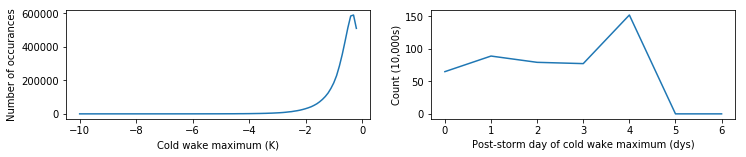

In [7]:
dir_figs = 'f:/data/tc_wakes/database/figs/hist/'
plt.figure(1, figsize=(12, 2))
plt.subplot(121)
plt.plot(cbin1[0:-1],ds_all.cnt1)
plt.xlabel('Cold wake maximum (K)')
plt.ylabel('Number of occurances')
plt.subplot(122)
plt.plot(cbin2[0:-1],ds_all.cnt2/10000)
plt.xlabel('Post-storm day of cold wake maximum (dys)')
plt.ylabel('Count (10,000s)')
plt.savefig(dir_figs+'coldwake_max.png')
plt.show()

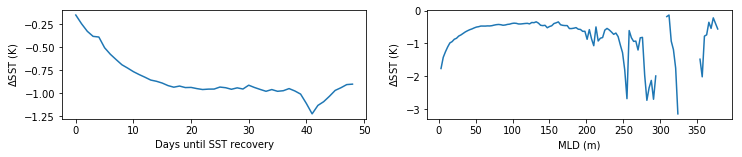

In [8]:
dir_figs = 'f:/data/tc_wakes/database/figs/hist/'
plt.figure(1, figsize=(12, 2))
plt.subplot(121)
plt.plot(cbin3[0:-1],ds_all.sum3/ds_all.cnt3)
plt.xlabel('Days until SST recovery')
plt.ylabel('$\Delta$SST (K)')
plt.subplot(122)
plt.plot(cbin4[0:-1],ds_all.sum4/ds_all.cnt4)
plt.xlabel('MLD (m)')
plt.ylabel('$\Delta$SST (K)')
plt.savefig(dir_figs+'coldwake_max.png')
plt.show()

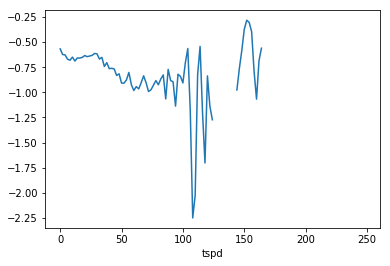

In [16]:
(ds_all.sum6/ds_all.cnt6).plot()  #storm translational speed versus cold wake anomaly

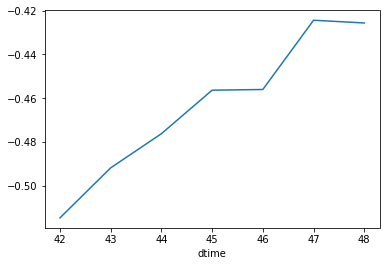

In [17]:
(ds_all.sum7/ds_all.cnt7).plot()

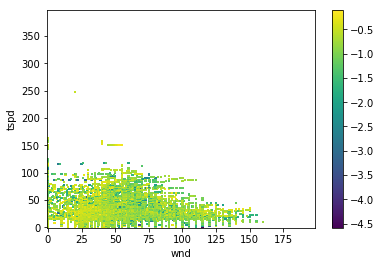

In [14]:
(ds_all.sum8/ds_all.cnt8).plot()

(array([2.0000e+00, 6.0000e+00, 1.3000e+01, 2.8000e+01, 7.6000e+01,
        2.0900e+02, 6.5500e+02, 2.5830e+03, 1.2030e+04, 3.1093e+04]),
 array([-6.92059896, -6.23853951, -5.55648005, -4.8744206 , -4.19236115,
        -3.51030169, -2.82824224, -2.14618278, -1.46412333, -0.78206388,
        -0.10000442]),
 <a list of 10 Patch objects>)

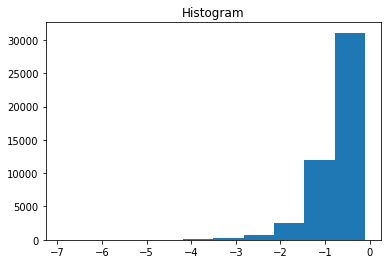

In [15]:
(ds_all.sum9/ds_all.cnt9).plot()

In [ ]:
plt.figure()
plt.pcolor(bins1,bins2,H.transpose())
plt.grid()
plt.xlabel('v1')
plt.ylabel('v2')
plt.colorbar()
plt.savefig(dir_figs+'coldwake_max.png')
plt.show()

<xarray.Dataset>
Dimensions:    (lat: 418, lon: 360, time: 12)
Coordinates:
  * lon        (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat        (lat) float32 -74.5 -74.16667 -73.83334 ... 64.16566 64.499
  * time       (time) datetime64[ns] 2018-01-01 2018-02-01 ... 2018-12-01
Data variables:
    date       (time) int32 ...
    timePlot   (time) float32 ...
    dbss_obml  (time, lat, lon) float32 ...
Attributes:
    creation_date:    Thu Jan  4 11:02:38 MST 2018
    sfcHeatFlux:      \nNote that the net surface heat flux are the total sur...
    time_comment:     The internal time stamp indicates the FIRST day of the ...
    Conventions:      COARDS
    grib_file:        godas.M.2018*
    html_REFERENCES:  http://www.cpc.ncep.noaa.gov/products/GODAS/background....
    html_BACKGROUND:  http://www.cpc.ncep.noaa.gov/products/GODAS/background....
    html_GODAS:       www.cpc.ncep.noaa.gov/products/GODAS
    comment:          NOTE:  THESE ARE THE BIAS CORRECTED GOD

In [ ]:
 

        #start saving this data
        
    for i in range(0,xdim):
        for j in range(0,ydim):
            if np.isnan(subset.analysed_sst[0,j,i]):  #don't process masked values
                continue
            storm_date64 = np.datetime64(date_1858 + dt.timedelta(days=float(ds_all.closest_storm_time[j,i])))
            time_diff = subset.time-storm_date64
            storm_index = np.argmin(abs(time_diff)).data

#            map_sum[j,i]+=subset.coldwake_max[j,i]
#            map_cnt[j,i]+=1
#            if  map_max[j,i]>subset.coldwake_max[j,i]:
#                map_max[j,i]=subset.coldwake_max[j,i]
            
            if subset.coldwake_max[j,i]<-0.1:  #cold wake larger than -0.1 
                icold=int(np.round(subset.coldwake_max[j,i].data*10.))+10
                icoldhr=int(np.round(subset.coldwake_hrtomaxcold[j,i].data))
                icolddy2=int(np.round(subset.coldwake_hrtorecovery[j,i].data/24.))
                iswnd=int(np.round(subset.wmo_storm_wind[j,i].data*.5))
                iwnd=int(np.round(subset.spd[storm_index,j,i].data))
                isspd=int(abs(np.round(subset.wmo_storm_speed[j,i].data)))

            #PROBLEM MLD interpolation pre 1/1 for each year need to fix
            #for now just setting first data to 1/1 for each year
                im=0
                if np.isnan(subset.dbss_obml[im,j,i].data):
                    while np.isnan(subset.dbss_obml[im,j,i].data):
                        im+=1
                        if im>=tdim:
                            break
                if im>=tdim:
                    continue
                if np.isnan(subset.dbss_obml[im,j,i].data):
                    continue
                imld=int(np.round(subset.dbss_obml[im,j,i].data))

                if (icold<0) | (icold>100):  #cold wake max between 0,10 K
                    continue
                if (icold>=0) & (icold<=100) & (isspd>=0) & (isspd<=200) & (imld>=0) & (imld<=100):                
                    if (iswnd>=0) & (iswnd<=100):             
                        sum1[icold,iswnd,isspd,imld]=sum1[icold,iswnd,isspd,imld]+subset.coldwake_max[j,i].data  #uses storm wind from wmo track
                        num1[icold,iswnd,isspd,imld]=num1[icold,iswnd,isspd,imld]+1  #uses storm wind from wmo track
                    if (iwnd>=0) & (iwnd<=100):                  
                        sum2[icold,iwnd,isspd,imld]=sum2[icold,iwnd,isspd,imld]+subset.coldwake_max[j,i].data    #uses collocated ccmp wind on storm day
                        num2[icold,iwnd,isspd,imld]=num2[icold,iwnd,isspd,imld]+1    #uses collocated ccmp wind on storm day
 #               if (icoldhr>=0) & (icoldhr<100):
 #                   num3[icoldhr]=num3[icoldhr]+1   #pdf of when max cold wake occurs
 #               if (icolddy2>=0) & (icolddy2<100):
 #                   num4[icolddy2]=num4[icolddy2]+1   #pdf of when recovery occurs
    #            num4[icold] = num4[icold]+1                     
 #               sum5[icold]=sum5[icold]+subset.coldwake_hrtorecovery[j,i].data  #mean of recorvery time as f(max coldwake)
 #               num5[icold]=num5[icold]+1  #mean of recorvery time as f(max coldwake)
 #               if (icoldhr>=0) & (icoldhr<100):
 #                   sum6[icoldhr]=sum6[icoldhr]+subset.coldwake_max[j,i].data  #mean of max cold wake as f(hr from storm)
 #                   num6[icoldhr]=num6[icoldhr]+1  #mean of max cold wake as f(hr from storm)

                #caluclate the mean sst anomaly as f(days after storm)
 #               for k in range(storm_index,tdim):
 #                   data_time = subset.time[k]
 #                   dtime = data_time-storm_date64
 #                   ddy = dtime / np.timedelta64(1,'D')
 #                   iddy = int(np.round(ddy))
 #                   if (iddy<0) | (iddy>50):
 #                       continue
 #                   change_in_sst = subset.sst_prestorm[j,i].data-subset.analysed_sst[k,j,i].data
 #                   sum7[iddy]=sum7[iddy]+change_in_sst  
 #                   num7[iddy]=num7[iddy]+1  

    for i in range(0,100):
        dim1[i]=(i-10)/10
        dim2[i]=i
        dim3[i]=i*24
        dim4[i]=i/.5
        dim5[i]=i
        dim7[i]=i
        dim8[i]=i
    for i in range(0,200):
        dim6[i]=i
#                                'num3': (('coldhr'),num3),
#                                'num4': (('colddy'),num4),
#                                'sum5': (('cold'),sum5),
#                                'num5': (('cold'),num5),
#                                'sum6': (('coldhr'),sum6),
#                                'num6': (('coldhr'),num6),
#                               'sum7': (('dyfrom'),sum7),
#                                'num7': (('dyfrom'),num7)
 
    m1=xr.DataArray(map_sum, coords={'lat': map_lats, 'lon':map_lons}, dims=('lat', 'lon'))        
    m2=xr.DataArray(map_cnt, coords={'lat': map_lats, 'lon':map_lons}, dims=('lat', 'lon'))        
    m3=xr.DataArray(map_max, coords={'lat': map_lats, 'lon':map_lons}, dims=('lat', 'lon'))        

    ds=xr.Dataset(data_vars={'sum1': (('cold','swnd','sspd','mld'),sum1),
                                'num1': (('cold','swnd','sspd','mld'),num1),
                                'sum2': (('cold','cwnd','sspd','mld'),sum2),
                                'num2': (('cold','cwnd','sspd','mld'),num2),
                                'map_sum': (('lat','lon'),m1),
                                'map_cnt': (('lat','lon'),m2),
                                'map_max': (('lat','lon'),m3)
                               },
                                 coords={'cold':dim1,'coldhr':dim2,'colddy':dim3,'swnd':dim4,
                                         'wnd':dim5,'sspd':dim6,'mld':dim7,'dyfrom':dim8,
                                         'lat':map_lats,'lon':map_lons})


In [ ]:

# coding: utf-8

# In[1]:


#plotting and data analysis for global cold wakes
#from netCDF4 import Dataset  # http://code.google.com/p/netcdf4-python/
import os
import time
import datetime as dt
import xarray as xr
from datetime import datetime
import pandas
import matplotlib.pyplot as plt
import numpy as np
import math
import geopy.distance
from math import sin, pi
from scipy import interpolate

#functions for running storm data
import sys

####################you will need to change some paths here!#####################
#list of input directories
dir_storm_info='f:/data/tc_wakes/database/info/'
dir_out='f:/data/tc_wakes/database/sst/'
#################################################################################

#start to look at data and make some pdfs

date_1858 = dt.datetime(1858,11,17,0,0,0) # start date is 11/17/1958

#init arrays
init_data=0
num1=np.zeros([101,101,201,101])
sum1=np.zeros([101,101,201,101])
num2=np.zeros([101,101,201,101])
sum2=np.zeros([101,101,201,101])
num3=np.zeros(101)
num4=np.zeros(101)
num5=np.zeros(101)
sum5=np.zeros(101)
num6=np.zeros(101)
sum6=np.zeros(101)
sum7=np.zeros(101)
num7=np.zeros(101)
dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8=np.zeros(101),np.zeros(101),np.zeros(101),np.zeros(101),np.zeros(101),np.zeros(201),np.zeros(101),np.zeros(101)

map_lats=np.arange(-90,90,.25)
map_lons=np.arange(-180,180,.25)
imap_lats = map_lats.size
imap_lons = map_lons.size
map_sum,map_cnt,map_max = np.zeros([imap_lats,imap_lons]),np.zeros([imap_lats,imap_lons]),np.zeros([imap_lats,imap_lons])
  
iyr_storm = 2003
for inum_storm in range(65,66): #(0,100): #100):
    filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_interpolated_track.nc'
    exists = os.path.isfile(filename)
    if not exists:
        continue
    print(filename)
    ds_storm_info=xr.open_dataset(filename)
    ds_storm_info = ds_storm_info.sel(j2=0)
    ds_storm_info.close()
    filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_combined_data_all.nc'
    ds_all = xr.open_dataset(filename)
    ds_all['spd']=np.sqrt(ds_all.uwnd**2+ds_all.vwnd**2)
    ds_all.close()
    if abs(ds_all.lon[-1]-ds_all.lon[0])>180:
        ds_all.coords['lon'] = np.mod(ds_all['lon'], 360)
        ds_storm_info['lon'] = np.mod(ds_storm_info['lon'], 360)
    max_lat = ds_storm_info.lat.max()
    #remove all data outsice 100km/800km or cold wake >0 or <-10
    if max_lat<0:
        cond = ((((ds_all.dist_from_storm_km<100) & (ds_all.side_of_storm<=0)) | 
        ((ds_all.dist_from_storm_km<800) & (ds_all.side_of_storm>0))) 
        & (ds_all.coldwake_max<=0) & (ds_all.coldwake_max>=-10))
    else:
        cond = ((((ds_all.dist_from_storm_km<800) & (ds_all.side_of_storm<0)) | 
        ((ds_all.dist_from_storm_km<100) & (ds_all.side_of_storm>=0))) 
        & (ds_all.coldwake_max<=0) & (ds_all.coldwake_max>=-10))
    subset = ds_all.where(cond)

    xdim,ydim,tdim = ds_all.lon.shape[0],ds_all.lat.shape[0],ds_all.time.shape[0]
    
    #change hr to recovery to day to recovery
    subset['coldwake_dytorecovery'] = subset.coldwake_hrtorecovery/24.
    
    #calculate the historgram and mean for the cold wakes
    cbin1 = np.arange(-10, 0, 0.1)  #cold wake bins
    subset_sum1=subset.groupby_bins('coldwake_max',cbin1).sum()  #sums number
    subset_cnt1=subset.groupby_bins('coldwake_max',cbin1).count()    #sums variable  
    cbin2 = np.arange(0,24*6)  #hour to max
    subset_sum2=subset.groupby_bins('coldwake_hrtomaxcold',cbin2).sum()  #sums number
    subset_cnt2=subset.groupby_bins('coldwake_hrtomaxcold',cbin2).count()    #sums variable
    cbin3 = np.arange(0,50)  #dy to recovery
    subset_sum3=subset.groupby_bins('coldwake_dytorecovery',cbin3).sum()  #sums number
    subset_cnt3=subset.groupby_bins('coldwake_dytorecovery',cbin3).count()    #sums variable
    cbin4 = np.arange(0,500)  #mld
    subset_sum4=subset.groupby_bins('dbss_obml',cbin4).sum()  #sums number
    subset_cnt4=subset.groupby_bins('dbss_obml',cbin4).count()    #sums variable
    cbin5 = np.arange(0,200)  #mld
    subset_sum5=subset.groupby_bins('spd',cbin5).sum()  #sums number
    subset_cnt5=subset.groupby_bins('spd',cbin5).count()    #sums variable

    sdate = np.empty([ydim,xdim], dtype=dt.datetime)    
    for i in range(0,xdim):
        for j in range(0,ydim):
            sdate[j,i] = np.datetime64(date_1858 + dt.timedelta(days=float(ds_all.closest_storm_time[j,i])))
    #xsdate=xr.DataArray(sdate, coords={'lat': ds_data.lat.values, 'lon':ds_data.lon.values}, dims=('lat', 'lon'))        
    sdate2 = np.empty([tdim,ydim,xdim])    
    for i in range(0,xdim):
        for j in range(0,ydim):
            if np.isnan(subset.analysed_sst[0,j,i]):  #don't process masked values
                continue
            for k in range(0,tdim):
                sdate2[k,j,i] = (ds_all.time[k] - sdate[j,i]) / np.timedelta64(1,'D')
    xsdate2=xr.DataArray(sdate2, coords={'time':ds_all.time, 'lat': ds_all.lat.values, 'lon':ds_all.lon.values}, dims=('time','lat', 'lon'))        
    ds_all['dys_from_storm2']=xsdate2
    cbin6 = np.arange(-10,50,1)  #cold wake bins
    subset_sum6=ds_all.groupby_bins('dys_from_storm2',cbin6).sum()  #sums number
    subset_cnt6=ds_all.groupby_bins('dys_from_storm2',cbin6).count()    #sums variable  

        #start saving this data
    if init_data == 0:
        sv_sum1,sv_cnt1 = subset_sum1,subset_cnt1
        sv_sum2,sv_cnt2 = subset_sum2,subset_cnt2
        sv_sum3,sv_cnt3 = subset_sum3,subset_cnt3
        sv_sum4,sv_cnt4 = subset_sum4,subset_cnt4
        sv_sum5,sv_cnt5 = subset_sum5,subset_cnt5
        sv_sum6,sv_cnt6 = subset_sum6,subset_cnt6
        init_data=1
    else:
        sv_sum1+= subset_sum1
        sv_cnt1+= subset_cnt1
        sv_sum2+= subset_sum2
        sv_cnt2+= subset_cnt2
        sv_sum3+= subset_sum3
        sv_cnt3+= subset_cnt3
        sv_sum4+= subset_sum4
        sv_cnt4+= subset_cnt4
        sv_sum5+= subset_sum5
        sv_cnt5+= subset_cnt5      
        sv_sum6+= subset_sum6
        sv_cnt6+= subset_cnt6           

        #put on global map
    tem = subset.coldwake_max.interp(lat=map_lats,lon=map_lons)
    tem=tem.fillna(0)
    temc=(tem/tem).fillna(0)
    map_sum+=tem
    map_cnt+=temc
    map_max=np.where(tem.data < map_max, tem,map_max)  #where tem<max put tem value in otherwise leave max
        
    for i in range(0,xdim):
        for j in range(0,ydim):
            if np.isnan(subset.analysed_sst[0,j,i]):  #don't process masked values
                continue
            storm_date64 = np.datetime64(date_1858 + dt.timedelta(days=float(ds_all.closest_storm_time[j,i])))
            time_diff = subset.time-storm_date64
            storm_index = np.argmin(abs(time_diff)).data

#            map_sum[j,i]+=subset.coldwake_max[j,i]
#            map_cnt[j,i]+=1
#            if  map_max[j,i]>subset.coldwake_max[j,i]:
#                map_max[j,i]=subset.coldwake_max[j,i]
            
            if subset.coldwake_max[j,i]<-0.1:  #cold wake larger than -0.1 
                icold=int(np.round(subset.coldwake_max[j,i].data*10.))+10
                icoldhr=int(np.round(subset.coldwake_hrtomaxcold[j,i].data))
                icolddy2=int(np.round(subset.coldwake_hrtorecovery[j,i].data/24.))
                iswnd=int(np.round(subset.wmo_storm_wind[j,i].data*.5))
                iwnd=int(np.round(subset.spd[storm_index,j,i].data))
                isspd=int(abs(np.round(subset.wmo_storm_speed[j,i].data)))

            #PROBLEM MLD interpolation pre 1/1 for each year need to fix
            #for now just setting first data to 1/1 for each year
                im=0
                if np.isnan(subset.dbss_obml[im,j,i].data):
                    while np.isnan(subset.dbss_obml[im,j,i].data):
                        im+=1
                        if im>=tdim:
                            break
                if im>=tdim:
                    continue
                if np.isnan(subset.dbss_obml[im,j,i].data):
                    continue
                imld=int(np.round(subset.dbss_obml[im,j,i].data))

                if (icold<0) | (icold>100):  #cold wake max between 0,10 K
                    continue
                if (icold>=0) & (icold<=100) & (isspd>=0) & (isspd<=200) & (imld>=0) & (imld<=100):                
                    if (iswnd>=0) & (iswnd<=100):             
                        sum1[icold,iswnd,isspd,imld]=sum1[icold,iswnd,isspd,imld]+subset.coldwake_max[j,i].data  #uses storm wind from wmo track
                        num1[icold,iswnd,isspd,imld]=num1[icold,iswnd,isspd,imld]+1  #uses storm wind from wmo track
                    if (iwnd>=0) & (iwnd<=100):                  
                        sum2[icold,iwnd,isspd,imld]=sum2[icold,iwnd,isspd,imld]+subset.coldwake_max[j,i].data    #uses collocated ccmp wind on storm day
                        num2[icold,iwnd,isspd,imld]=num2[icold,iwnd,isspd,imld]+1    #uses collocated ccmp wind on storm day
 #               if (icoldhr>=0) & (icoldhr<100):
 #                   num3[icoldhr]=num3[icoldhr]+1   #pdf of when max cold wake occurs
 #               if (icolddy2>=0) & (icolddy2<100):
 #                   num4[icolddy2]=num4[icolddy2]+1   #pdf of when recovery occurs
    #            num4[icold] = num4[icold]+1                     
 #               sum5[icold]=sum5[icold]+subset.coldwake_hrtorecovery[j,i].data  #mean of recorvery time as f(max coldwake)
 #               num5[icold]=num5[icold]+1  #mean of recorvery time as f(max coldwake)
 #               if (icoldhr>=0) & (icoldhr<100):
 #                   sum6[icoldhr]=sum6[icoldhr]+subset.coldwake_max[j,i].data  #mean of max cold wake as f(hr from storm)
 #                   num6[icoldhr]=num6[icoldhr]+1  #mean of max cold wake as f(hr from storm)

                #caluclate the mean sst anomaly as f(days after storm)
 #               for k in range(storm_index,tdim):
 #                   data_time = subset.time[k]
 #                   dtime = data_time-storm_date64
 #                   ddy = dtime / np.timedelta64(1,'D')
 #                   iddy = int(np.round(ddy))
 #                   if (iddy<0) | (iddy>50):
 #                       continue
 #                   change_in_sst = subset.sst_prestorm[j,i].data-subset.analysed_sst[k,j,i].data
 #                   sum7[iddy]=sum7[iddy]+change_in_sst  
 #                   num7[iddy]=num7[iddy]+1  

    for i in range(0,100):
        dim1[i]=(i-10)/10
        dim2[i]=i
        dim3[i]=i*24
        dim4[i]=i/.5
        dim5[i]=i
        dim7[i]=i
        dim8[i]=i
    for i in range(0,200):
        dim6[i]=i
#                                'num3': (('coldhr'),num3),
#                                'num4': (('colddy'),num4),
#                                'sum5': (('cold'),sum5),
#                                'num5': (('cold'),num5),
#                                'sum6': (('coldhr'),sum6),
#                                'num6': (('coldhr'),num6),
#                               'sum7': (('dyfrom'),sum7),
#                                'num7': (('dyfrom'),num7)
 
    m1=xr.DataArray(map_sum, coords={'lat': map_lats, 'lon':map_lons}, dims=('lat', 'lon'))        
    m2=xr.DataArray(map_cnt, coords={'lat': map_lats, 'lon':map_lons}, dims=('lat', 'lon'))        
    m3=xr.DataArray(map_max, coords={'lat': map_lats, 'lon':map_lons}, dims=('lat', 'lon'))        

    ds=xr.Dataset(data_vars={'sum1': (('cold','swnd','sspd','mld'),sum1),
                                'num1': (('cold','swnd','sspd','mld'),num1),
                                'sum2': (('cold','cwnd','sspd','mld'),sum2),
                                'num2': (('cold','cwnd','sspd','mld'),num2),
                                'map_sum': (('lat','lon'),m1),
                                'map_cnt': (('lat','lon'),m2),
                                'map_max': (('lat','lon'),m3)
                               },
                                 coords={'cold':dim1,'coldhr':dim2,'colddy':dim3,'swnd':dim4,
                                         'wnd':dim5,'sspd':dim6,'mld':dim7,'dyfrom':dim8,
                                         'lat':map_lats,'lon':map_lons})


In [ ]:
#subset.spd.max('time').plot()
#subset.coldwake_max.plot()
subset.dbss_obml[20,:,:].plot()
#subset.hum2m[0,:,:].plot()

In [ ]:
subset.time

In [ ]:
subset.sst_prestorm[40,100].data
i,j = 100,40
storm_date = date_1858 + dt.timedelta(days=float(ds_all.closest_storm_time[j,i]))  #create new time array that can be queried for year etc
storm_date64 = np.datetime64(storm_date)
#print(subset.time)
time_diff = subset.time-storm_date64
storm_index = np.argmin(abs(time_diff)).data
istart,iend = int(storm_index)-1,int(storm_index)+5
if istart<0:
    istart=0
if iend>tdim:
    iend=tdim
coldwake_max[j,i] = (subset.sst_prestorm[j,i]-subset.analysed_sst[istart:iend,j,i]).min()
itmp = np.argmin(subset.sst_prestorm[j,i]-subset.analysed_sst[istart:iend,j,i])
print(itmp)
print(subset.sst_prestorm[j,i].values,subset.analysed_sst[istart:iend,j,i].values)
print(istart,iend)
print(coldwake_max[j,i])

In [ ]:
(subset.sst_prestorm[j,i]-subset.analysed_sst[istart:iend,j,i]).plot()

In [ ]:
import dask.array as da
import numpy as np
import matplotlib.pyplot as plt

### create a dataset
nxc, nyc = 1000,1000
nx, ny = nxc*8*7, nyc*8*7
v = da.random.normal(0., .5, size=(nx,ny), chunks=(nxc, nyc))
v1 = v
v2 = v + da.random.normal(1., .5, size=(nx,ny), chunks=(nxc, nyc))

v1min, v1max, dv1= -2., 2., .1
v2min, v2max, dv2= -1., 3., .05
i1max = int(np.rint((v1max-v1min)/dv1))+1
i2max = int(np.rint((v2max-v2min)/dv2))+1
def get_index(v1,v2):
    ''' This function provides the index of (v1,v2) coupled value position
    in the 2D histogram array
    '''
    i1 = np.maximum(np.rint((v1-v1min)/dv1)+1,0)
    i1 = np.minimum(i1,i1max)
    i2 = np.maximum(np.rint((v2-v2min)/dv2)+1,0)
    i2 = np.minimum(i2,i2max)
    return i1+i2*(i1max+1)
# apply get_index to v1 and v2 arrays
v12 = da.map_blocks(get_index, v1, v2, dtype='float')
# compute histogram of linear indices
h, lbins = da.histogram(v12, bins=np.arange(-.5,(i1max+1)*(i2max+1)+0.5,1.))
# normalize and reshape
H = h.compute()
H = H*1./H.sum()
H = H.reshape((i1max+1,i2max+1), order='F')

# compute bins
bins1 = np.arange(v1min-dv1, v1max+dv1, dv1)
bins2 = np.arange(v2min-dv2, v2max+dv2, dv2)
bins1, bins2 = np.meshgrid(bins1,bins2)

#
plt.figure()
plt.pcolor(bins1,bins2,H.transpose())
plt.grid()
plt.xlabel('v1')
plt.ylabel('v2')
plt.colorbar()



In [ ]:
v

In [ ]:
iyr_storm = 2015
inum_storm = 50
filename = dir_out + str(iyr_storm) + '/' + str(inum_storm).zfill(3) + '_interpolated_track.nc'
exists = os.path.isfile(filename)
print(filename)
ds_storm_info=xr.open_dataset(filename)
ds_storm_info = ds_storm_info.sel(j2=0)
ds_storm_info.close()


In [ ]:
ds_storm_info

In [ ]:
ds_storm_info.time